# 房价预测

## 导入模块

In [5]:
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import random

## 数据处理

In [6]:

def load_data():
    # 从当前目录下./data/housing.data导入数据
    datafile = '/mnt/e/Users/Administrator/Desktop/wsl_user/paddle/test/data/housing.data'
    data = np.fromfile(datafile, sep=' ', dtype=np.float32)

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算train数据集每一列的最大值，最小值
    maximums, minimums = training_data.max(axis=0), training_data.min(axis=0)
    
    # 记录数据的归一化参数，在预测时对数据做归一化
    global max_values
    global min_values
   
    max_values = maximums
    min_values = minimums
    
    # 对数据进行归一化处理
    for i in range(feature_num):
        data[:, i] = (data[:, i] - min_values[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data


## 构建网络模型

In [7]:
class Regressor(paddle.nn.Layer):

    # self代表类的实例自身
    def __init__(self):
        # 初始化父类中的一些参数
        super(Regressor, self).__init__()
        
        # 定义一层全连接层，输入维度是13，输出维度是1
        self.fc = Linear(in_features=13, out_features=1)
    
    # 网络的前向计算
    def forward(self, inputs):
        x = self.fc(inputs)
        return x

## 训练模型

In [65]:
# 声明定义好的线性回归模型
model = Regressor()

# 开启模型训练模式
model.train()

# 加载数据
training_data, test_data = load_data()

# 定义优化算法，使用随机梯度下降SGD
# 学习率设置为0.01
opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())

EPOCH_NUM = 10   # 设置外层循环次数
BATCH_SIZE = 10  # 设置batch大小
losses = []

# 定义外层循环
for epoch_id in range(EPOCH_NUM):
    # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
    np.random.shuffle(training_data)
    # 将训练数据进行拆分，每个batch包含10条数据
    mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
    # 定义内层循环
    for iter_id, mini_batch in enumerate(mini_batches):
        x = np.array(mini_batch[:, :-1])
        y = np.array(mini_batch[:, -1:])
        # 将numpy数据转为tensor的格式
        house_features = paddle.to_tensor(x)
        prices = paddle.to_tensor(y)
        
        # 前向计算
        predicts = model(house_features)

        # 计算损失
        loss = F.square_error_cost(predicts, label=prices)
        avg_loss = paddle.mean(loss)
        losses.append(avg_loss)
        if iter_id%40==0:
            print("epoch: {}, iter: {}, loss is: {}".format(epoch_id, iter_id, avg_loss.item()))
        
        # 反向传播，计算每层参数的梯度值
        avg_loss.backward()
        # 更新参数，根据设置好的学习率迭代一步
        opt.step()
        # 清空梯度变量，以备下一轮计算
        opt.clear_grad()

epoch: 0, iter: 0, loss is: 0.059536851942539215
epoch: 0, iter: 40, loss is: 0.03923073410987854
epoch: 1, iter: 0, loss is: 0.22754144668579102
epoch: 1, iter: 40, loss is: 0.026738785207271576
epoch: 2, iter: 0, loss is: 0.04483967646956444
epoch: 2, iter: 40, loss is: 0.03559575229883194
epoch: 3, iter: 0, loss is: 0.04834415763616562
epoch: 3, iter: 40, loss is: 0.06855448335409164
epoch: 4, iter: 0, loss is: 0.11893993616104126
epoch: 4, iter: 40, loss is: 0.05228143930435181
epoch: 5, iter: 0, loss is: 0.12282373011112213
epoch: 5, iter: 40, loss is: 0.09874562919139862
epoch: 6, iter: 0, loss is: 0.03225652500987053
epoch: 6, iter: 40, loss is: 0.16716311872005463
epoch: 7, iter: 0, loss is: 0.03228963539004326
epoch: 7, iter: 40, loss is: 0.04652004688978195
epoch: 8, iter: 0, loss is: 0.06497674435377121
epoch: 8, iter: 40, loss is: 0.03455793112516403
epoch: 9, iter: 0, loss is: 0.01776551455259323
epoch: 9, iter: 40, loss is: 0.049316100776195526


## 绘制损失趋势

<function matplotlib.pyplot.show(close=None, block=None)>

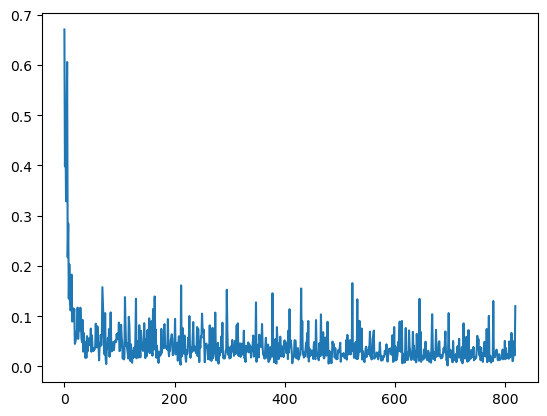

In [58]:
# 绘制损失函数变化趋势
plot_x = np.arange(len(losses))
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show

## 模型保存和测试

In [59]:
    # 保存模型参数，文件名为LR_model.pdparams
    paddle.save(model.state_dict(), './paddle/LR_model.pdparams')
    print("模型参数保存在./paddle/LR_model.pdparams中")

模型参数保存在./paddle/LR_model.pdparams中


In [64]:
# 数据集中抽一条样本作为测试样本
def load_one_example():
    # 从上边已加载的测试集中，随机选择一条作为测试数据
    idx = np.random.randint(0, test_data.shape[0])
    one_data, label = test_data[idx, :-1], test_data[idx, -1]
    # 修改该条数据shape为[1,13]
    one_data =  one_data.reshape([1,-1])

    return one_data, label

# 导入模型参数文件
model_dict = paddle.load('./paddle/LR_model.pdparams')
model.load_dict(model_dict)
model.eval()

# 参数为数据集的文件地址
one_data, label = load_one_example()
# 将数据转为动态图的variable格式 
one_data = paddle.to_tensor(one_data)
predict = model(one_data)

# 对结果做反归一化处理
predict = predict * (max_values[-1] - min_values[-1]) + min_values[-1]
# 对label数据做反归一化处理
label = label * (max_values[-1] - min_values[-1]) + min_values[-1]

# 打印测试结果
print("Inference result is {}, the corresponding label is {}".format(predict.numpy(), label))


Inference result is [[13.060189]], the corresponding label is 13.800000190734863
